# Let's do some experiements on real data: Time-Series Predictions

## Time-Series
* Data measured against points in time. The resolution can be minutes like in weather, it can be in years like in annual GDP of a country, it can be in days/months/years sea surface emprature, sea surface height of ocean

* We can do forecasting, interpolation, extrapolation, corelation, analysis, etc...

## Gathering data
* Global warming is the ongoing rise of the average temperature of the Earth's climate system and has been demonstrated by direct temperature measurements and by measurements of various effects of the warming
* So a dataset on the temperature of major cities of the world will help analyze the same. Also weather information is helpful for a lot of data science tasks like sales forecasting, logistics etc

## Contents
* Daily level average temperature values is present in city_temperature.csv file

## Prepare data

The data is in a compressed csv file. We first need to unzip it:

## Technical preamble

In [1]:
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data visualization

## Read data

The data is in a compressed csv file. We first need to unzip it:

In [2]:
!(cd data/ && unzip -o city_temperature.csv.zip)
!cat data/city_temperature/licence

Archive:  city_temperature.csv.zip
  inflating: city_temperature/city_temperature.csv  
  inflating: city_temperature/licence  
==== city_temperature.csv ====

This CSV file was downloaded from https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities on 2020-11-17.

The original data were assembled by Sudalai Rajkumar (https://www.kaggle.com/sudalairajkumar) from data provided by the University of Dayton (http://academic.udayton.edu/kissock/http/Weather/default.htm).

In [3]:
df = pd.read_csv('data/city_temperature/city_temperature.csv')

/srv/conda/envs/notebook/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
display(df)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [5]:
df = df.iloc[:3650]
df = df[["Year", "Month", "Day", "AvgTemperature"]]
df

,Year,Month,Day,AvgTemperature
0,1995,1,1,64.2
1,1995,1,2,49.4
2,1995,1,3,48.8
3,1995,1,4,46.4
4,1995,1,5,47.9
...,...,...,...,...
3645,2004,12,24,46.6
3646,2004,12,25,52.4
3647,2004,12,26,47.4
3648,2004,12,27,44.9


## Use real time stamps

There seem to be a few time stamps that are wrong. Let's just replace them with `NaT`.

In [6]:
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]], errors='coerce')

In [7]:
display(df)

,Year,Month,Day,AvgTemperature,Date
0,1995,1,1,64.2,1995-01-01
1,1995,1,2,49.4,1995-01-02
2,1995,1,3,48.8,1995-01-03
3,1995,1,4,46.4,1995-01-04
4,1995,1,5,47.9,1995-01-05
...,...,...,...,...,...
3645,2004,12,24,46.6,2004-12-24
3646,2004,12,25,52.4,2004-12-25
3647,2004,12,26,47.4,2004-12-26
3648,2004,12,27,44.9,2004-12-27


In [8]:
df = df[["Date", "AvgTemperature"]]
df

,Date,AvgTemperature
0,1995-01-01,64.2
1,1995-01-02,49.4
2,1995-01-03,48.8
3,1995-01-04,46.4
4,1995-01-05,47.9
...,...,...
3645,2004-12-24,46.6
3646,2004-12-25,52.4
3647,2004-12-26,47.4
3648,2004-12-27,44.9


## Have a look at temperature

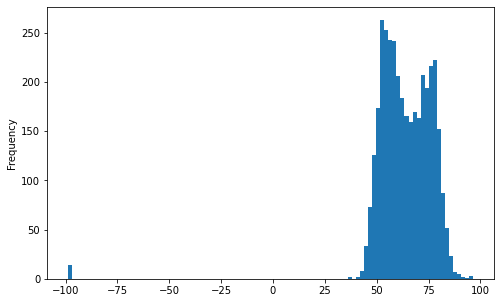

In [9]:
df.AvgTemperature.plot.hist(bins=100, figsize=(8, 5));

In [10]:
df.AvgTemperature.describe()

count    3650.000000
mean       63.782767
std        14.624069
min       -99.000000
25%        55.300000
50%        63.400000
75%        73.600000
max        96.600000
Name: AvgTemperature, dtype: float64

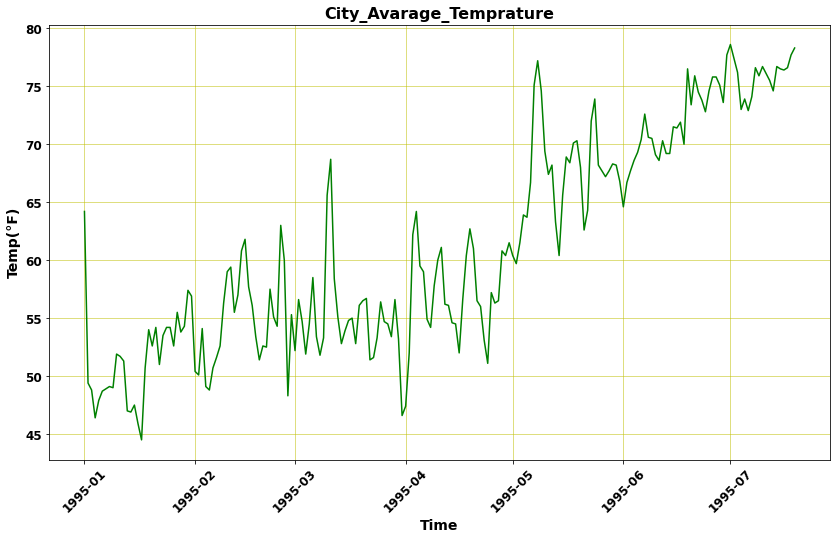

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(14, 8))
plt.plot(df.Date[:200], df.AvgTemperature[0:200], color='g')
plt.title('City_Avarage_Temprature', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Temp(°F)', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

### Data_Preprocessing
* Features Extraction

In [12]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
 
    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    return df_copy

In [13]:
list_of_attributes = ['AvgTemperature']

list_of_prev_t_instants = []
for i in range(1,16):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [14]:
df_new = create_regressor_attributes(df, list_of_attributes, list_of_prev_t_instants)
df_new

,Date,AvgTemperature,AvgTemperature_(t-1),AvgTemperature_(t-2),AvgTemperature_(t-3),AvgTemperature_(t-4),AvgTemperature_(t-5),AvgTemperature_(t-6),AvgTemperature_(t-7),AvgTemperature_(t-8),AvgTemperature_(t-9),AvgTemperature_(t-10),AvgTemperature_(t-11),AvgTemperature_(t-12),AvgTemperature_(t-13),AvgTemperature_(t-14),AvgTemperature_(t-15)
0,1995-01-16,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4,64.2
1,1995-01-17,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4
2,1995-01-18,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8
3,1995-01-19,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4
4,1995-01-20,52.6,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,2004-12-24,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6,53.2
3631,2004-12-25,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6
3632,2004-12-26,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4
3633,2004-12-27,44.9,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8


In [15]:
df_new.shape

(3635, 17)

In [16]:
df_new.columns

Index(['Date', 'AvgTemperature', 'AvgTemperature_(t-1)',
       'AvgTemperature_(t-2)', 'AvgTemperature_(t-3)', 'AvgTemperature_(t-4)',
       'AvgTemperature_(t-5)', 'AvgTemperature_(t-6)', 'AvgTemperature_(t-7)',
       'AvgTemperature_(t-8)', 'AvgTemperature_(t-9)', 'AvgTemperature_(t-10)',
       'AvgTemperature_(t-11)', 'AvgTemperature_(t-12)',
       'AvgTemperature_(t-13)', 'AvgTemperature_(t-14)',
       'AvgTemperature_(t-15)'],
      dtype='object')

In [17]:
df_new = df_new.drop(columns=["Date", ])
df_new

,AvgTemperature,AvgTemperature_(t-1),AvgTemperature_(t-2),AvgTemperature_(t-3),AvgTemperature_(t-4),AvgTemperature_(t-5),AvgTemperature_(t-6),AvgTemperature_(t-7),AvgTemperature_(t-8),AvgTemperature_(t-9),AvgTemperature_(t-10),AvgTemperature_(t-11),AvgTemperature_(t-12),AvgTemperature_(t-13),AvgTemperature_(t-14),AvgTemperature_(t-15)
0,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4,64.2
1,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8,49.4
2,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4,48.8
3,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9,46.4
4,52.6,54.0,50.7,44.5,45.9,47.5,46.9,47.0,51.3,51.7,51.9,49.0,49.1,48.9,48.7,47.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6,53.2
3631,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4,55.6
3632,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8,52.4
3633,44.9,47.4,52.4,46.6,48.3,52.6,52.2,57.2,57.4,55.3,56.7,56.3,59.2,53.3,51.8,51.8


### Building_Neural_Network_model

In [18]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [19]:
input_layer = Input(shape=(15), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                960       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________


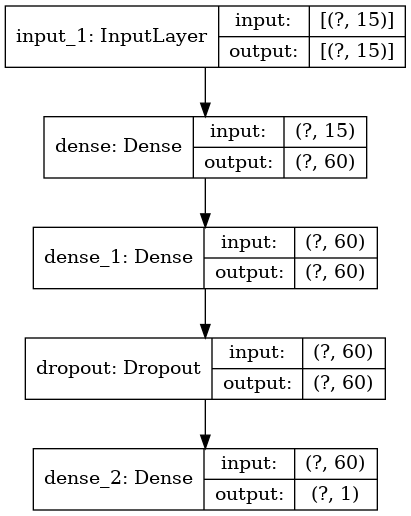

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

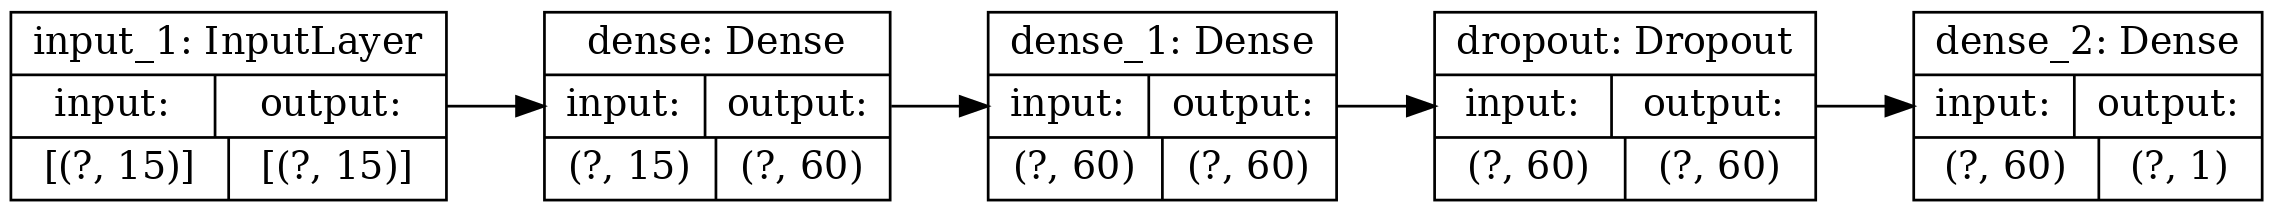

In [21]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="LR", #'TB' creates a vertical plot; 'LR' creates a horizontal plot.
    expand_nested=True,
    dpi=196,
)

In [22]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (3280, 15) (3280,)
Shape of validation inputs, validation target: (173, 15) (173,)
Shape of test inputs, test target: (182, 15) (182,)


### Scaling the data
* Normalize our data in the range in the range (0.01, 0.99) before feeding it to the the neural network
* MinMaxScaler() function takes in dataframes or series (can also take in arrays), but it always returns n-dimensional arrays.

In [23]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

In [24]:
model.fit(
    x=X_train_scaled[0:2200],
    y=y_train_scaled[0:2200],
    batch_size=256, epochs=10, verbose=1,
    validation_data=(X_valid_scaled, y_valid_scaled),
    shuffle=True
)

Epoch 1/10
9/9 [==============================] - 11s 1s/step - loss: 0.3640 - val_loss: 0.0186
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.1631 - val_loss: 0.0210
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.1069 - val_loss: 0.0180
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.0706 - val_loss: 0.0205
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.0566 - val_loss: 0.0175
Epoch 6/10
9/9 [==============================] - 13s 1s/step - loss: 0.0483 - val_loss: 0.0199
Epoch 7/10
9/9 [==============================] - 10s 1s/step - loss: 0.0392 - val_loss: 0.0171
Epoch 8/10
9/9 [==============================] - 19s 2s/step - loss: 0.0339 - val_loss: 0.0176
Epoch 9/10
9/9 [==============================] - 10s 1s/step - loss: 0.0267 - val_loss: 0.0179
Epoch 10/10
9/9 [==============================] - 10s 1s/step - loss: 0.0233 - val_loss: 0.0168


In [25]:
y_pred = model.predict(X_test_scaled)

In [26]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [27]:
from sklearn.metrics import mean_squared_error
mse_model=mean_squared_error(y_test_scaled[100:800], y_pred[100:800])
print('mse of NN:', mse_model)

mse of NN: 0.012377278488978408


In [28]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.7661


In [29]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Temperature'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Temperature'])

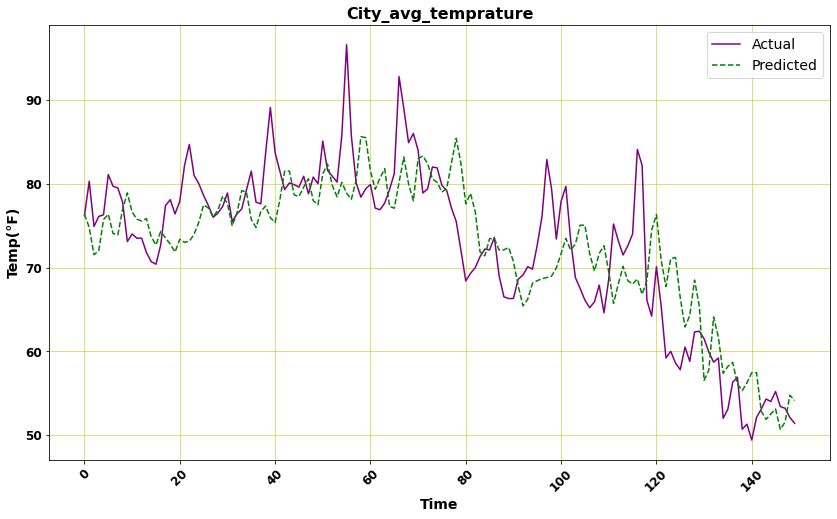

In [30]:
plt.figure(figsize=(14, 8))
plt.plot(y_actual[0:150], linestyle='solid', color='purple')
plt.plot(y_hat[0:150], linestyle='dashed', color='green')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('City_avg_temprature', weight='bold', fontsize=16)
plt.ylabel('Temp(°F)', weight='bold', fontsize=14)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Tips: Ecosystem

#### How To Install The Ecosystem: An Easier Way
* If you are not confident at installing software on your machine, there is an easier option
* There is a distribution called Anaconda that you can download and install for free
* It supports the three main platforms of Microsoft Windows, Mac OS X and Linux
* It includes Python, SciPy and scikit-learn. Everything you need to learn, practice and use machine learning with the Python Environment